**Name:** Mosab Mohamed</br>
**Email:** o.mohamed@innopolis.university


<h3>Imports:</h3>

In [1091]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


%matplotlib inline

<h3>Load Data:</h3>

In [1092]:
df = pd.read_csv('a1_dataset.csv')
df = df.sort_values('var7')
#Printing some information about the dataset
print(df.shape)
print(df.head())
print(df.describe())

(925, 8)
     target    var1     var2       var3  var4    var5 var6  \
500       0  479.88  608.030    Bermuda   NaN  404.70  yes   
445       0  423.66  634.976       Guam   NaN  393.85  yes   
653       1  391.78  428.383     Uganda   NaN  182.80  yes   
544       1  272.36  658.567   Ethiopia   NaN  233.05  yes   
754       0  467.20  599.985  Mauritius   NaN  376.60   no   

                    var7  
500  2019-01-01 05:31:22  
445  2019-01-01 08:27:06  
653  2019-01-01 15:14:24  
544  2019-01-01 20:17:49  
754  2019-01-01 21:58:55  
           target        var1        var2        var4        var5
count  925.000000  925.000000  925.000000  325.000000  925.000000
mean     0.496216  360.116562  548.390134  108.452308  325.393946
std      0.500256   87.866662  135.221460   26.325744   78.862779
min      0.000000  209.560000  139.965000   57.000000  163.000000
25%      0.000000  278.640000  467.373000   87.000000  257.900000
50%      0.000000  367.640000  569.841000  105.000000  342.3

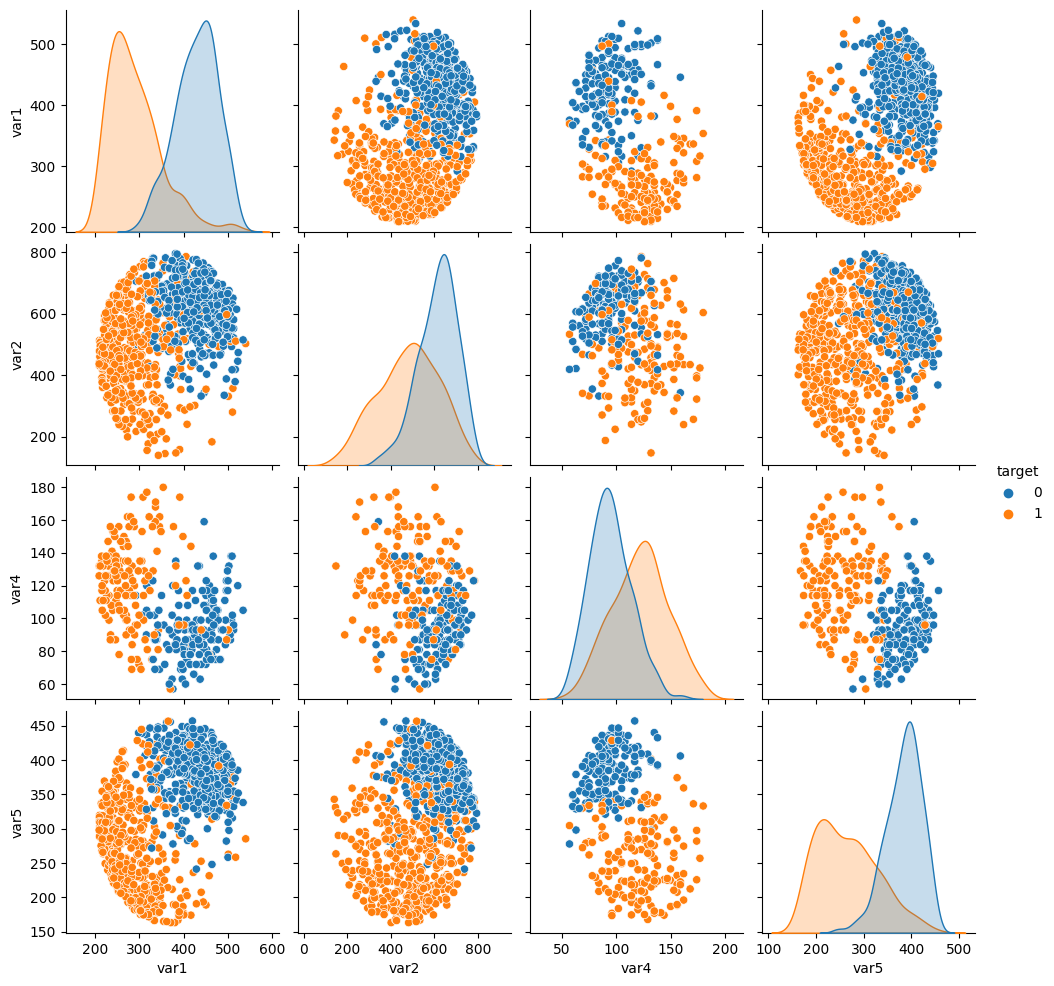

In [1093]:
#Plotting pairwise relationships
sb.pairplot(df, hue='target')


<h1>Preprocessing</h1>

<h3>Encoding categorical values</h3>

In [1094]:
def encoder_new_df(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names())
    new_df = pd.DataFrame(df) 
    new_df.drop(features_name, axis=1, inplace=True)
    new_df = pd.concat([new_df, new_cols], axis=1)  
    return new_df


In [1095]:
one_hot_encoder = ce.OneHotEncoder()
ordinal_encoder = ce.OrdinalEncoder()
target_encoder = ce.TargetEncoder()

ordinal_encoder.fit(df['var7']) #Date column
df = encoder_new_df(df, ['var7'], ordinal_encoder)

f_names = ['var3', 'var6'] #Columns to be encoded

one_hot_encoder.fit(df[f_names])
onehot_encoded_df = encoder_new_df(df, f_names, one_hot_encoder)

ordinal_encoder.fit(df[f_names])
ordinal_encoded_df = encoder_new_df(df, f_names, ordinal_encoder)

target_encoder.fit(df[f_names], df['target'])
target_encoded_df = encoder_new_df(df, f_names, ordinal_encoder) 

df = ordinal_encoded_df
df

/home/iviosab/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/iviosab/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,target,var1,var2,var4,var5,var7,var3,var6
500,0,479.88,608.030,NaN,404.70,1,1,1
445,0,423.66,634.976,NaN,393.85,2,2,1
653,1,391.78,428.383,NaN,182.80,3,3,1
544,1,272.36,658.567,NaN,233.05,4,4,1
754,0,467.20,599.985,NaN,376.60,5,5,2
...,...,...,...,...,...,...,...,...
152,1,227.38,586.777,135.0,337.95,921,207,1
410,0,451.98,403.455,NaN,370.30,922,66,1
101,1,224.38,602.235,126.0,309.40,923,79,2
502,1,301.68,240.301,NaN,400.15,924,167,1


<h2>Data imputation</h2>

Splitting

In [1096]:
#Split to NaN and known
var4_df = df[~df['var4'].isnull()]
var4_nan_df = df[df['var4'].isnull()]


df_corr = var4_df.corr()['var4'].abs().sort_values(ascending=False)
cols = df_corr[df_corr > 0.2].index.to_list()[1:]

X = var4_df[cols]
y = var4_df.var4.values

#Split Known to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1097]:
#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Linear Regression

In [1098]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print_metrics_error(y_test,y_pred)

Mean Absolute Error: 19.224571460472475
Mean Squared Error: 583.061695587879
Root Mean Squared Error: 24.146670486588395


Polynomial Regression

In [1099]:
for i in [2,3,4]:
    pipeline = polynomial_regression(degree=i)
    y_pred_poly = pipeline.predict(X_test)
    print(f"degree {i}:")
    print_metrics_error(y_test,y_pred_poly)

degree = 2 #degree with the best MSE
pipeline = polynomial_regression(degree)
y_pred_poly = pipeline.predict(X_test)

degree 2:
Mean Absolute Error: 16.772887804019145
Mean Squared Error: 519.6559023806977
Root Mean Squared Error: 22.79596241400432
degree 3:
Mean Absolute Error: 16.27235576923077
Mean Squared Error: 714.5425893930288
Root Mean Squared Error: 26.730929452471884
degree 4:
Mean Absolute Error: 21.720192307692308
Mean Squared Error: 1693.132677283654
Root Mean Squared Error: 41.14769346249743


In [1100]:

X = var4_nan_df[cols]
X = scaler.transform(X)

poly_var4 = pipeline.predict(X)
poly_var4 = np.append(y, poly_var4, 0)
poly_df = df.drop('var4', axis=1)
poly_var4 = pd.DataFrame(poly_var4, dtype=int, columns=['var4'])
poly_df = pd.concat([poly_df, poly_var4], axis=1)


/tmp/ipykernel_232825/425607893.py:7: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  poly_var4 = pd.DataFrame(poly_var4, dtype=int, columns=['var4'])


PCA TODO

In [1101]:
df = poly_df
df

,target,var1,var2,var5,var7,var3,var6,var4
500,0,479.88,608.030,404.70,1,1,1,122
445,0,423.66,634.976,393.85,2,2,1,127
653,1,391.78,428.383,182.80,3,3,1,89
544,1,272.36,658.567,233.05,4,4,1,105
754,0,467.20,599.985,376.60,5,5,2,120
...,...,...,...,...,...,...,...,...
152,1,227.38,586.777,337.95,921,207,1,81
410,0,451.98,403.455,370.30,922,66,1,103
101,1,224.38,602.235,309.40,923,79,2,99
502,1,301.68,240.301,400.15,924,167,1,102


In [1102]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)


In [1103]:
def plot(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  pca = PCA(n_components=2)
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  feature1 = X_train[:, 0]
  feature2 = X_train[:, 1]
  plt.scatter(
        feature1, feature2, c=y_train, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

  plt.colorbar()
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.show()

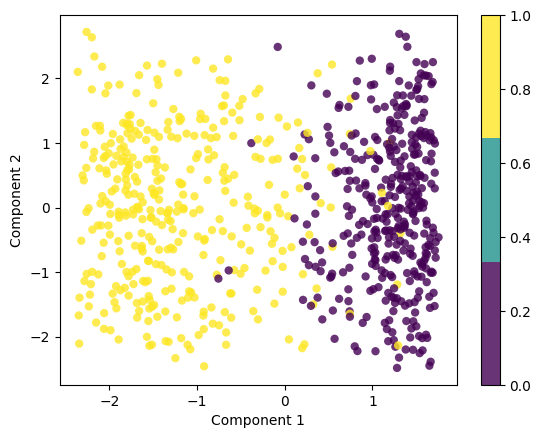

In [1104]:
X = df.drop('target', axis=1)
y = df['target']
plot(X, y)

<h1>TRAINING</h1>

In [1105]:
df_corr = poly_df.corr()['target'].abs().sort_values(ascending=False)
features = df_corr[df_corr > 0.1].index.to_list()[1:]
features
print(list(df_corr))

[1.0, 0.7840982038577169, 0.7478031750023001, 0.49549232896140577, 0.044704966788964344, 0.0365660662108099, 0.01619495846891356, 0.012173631789640007]


In [1106]:
#logistic
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [500, 1000, 2000]
}
clf = LogisticRegression()

grid_search_clf = GridSearchCV(estimator=clf,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)

print_metrics_APR(y_test, y_test_pred)


Testing accuracy = 0.9405405405405406
Testing precision = 0.9886363636363636
Testing recall = 0.8969072164948454


In [1107]:
#logistic with pca
X = poly_df.drop('target', axis=1)
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [500, 1000, 2000]
}
clf = LogisticRegression()

grid_search_clf = GridSearchCV(estimator=clf,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)

print_metrics_APR(y_test, y_test_pred)


Testing accuracy = 0.9405405405405406
Testing precision = 0.9777777777777777
Testing recall = 0.9072164948453608


In [1108]:
#KNN
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

param_grid = {'n_neighbors':list(range(1, 11)),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'cosine']
              }
clf = KNeighborsClassifier()
grid_search_clf = GridSearchCV(estimator=clf,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)
print(grid_search_clf.best_params_)

print_metrics_APR(y_test, y_test_pred)


{'metric': 'cosine', 'n_neighbors': 4, 'weights': 'uniform'}
Testing accuracy = 0.918918918918919
Testing precision = 0.9880952380952381
Testing recall = 0.8556701030927835


In [1109]:
#KNN with pca
X = poly_df.drop('target', axis=1)
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = scale(X_train, X_test)

pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
param_grid = {'n_neighbors':list(range(1, 11)),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'cosine']
              }
clf = KNeighborsClassifier()
grid_search_clf = GridSearchCV(estimator=clf,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)
print_metrics_APR(y_test, y_test_pred)



Testing accuracy = 0.9459459459459459
Testing precision = 0.978021978021978
Testing recall = 0.9175257731958762


In [1110]:
#Naive 
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
gauss_nb = GaussianNB()

grid_search_clf = GridSearchCV(estimator=gauss_nb,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)

print_metrics_APR(y_test, y_test_pred)


Testing accuracy = 0.9459459459459459
Testing precision = 1.0
Testing recall = 0.8969072164948454


In [1111]:
#Naive with pca
X = poly_df[features]
y = poly_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = LogisticRegression()

grid_search_clf = GridSearchCV(estimator=gauss_nb,
                        cv=3, scoring='accuracy',
                        param_grid=param_grid)

grid_search_clf.fit(X_train, y_train)
y_test_pred = grid_search_clf.predict(X_test)

print_metrics_APR(y_test, y_test_pred)


Testing accuracy = 0.9297297297297298
Testing precision = 0.9666666666666667
Testing recall = 0.8969072164948454
